<a href="https://colab.research.google.com/github/rohinishimpatwar/DeepLearning/blob/master/DogBreedClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!unzip -uq "/content/drive/My Drive/DeepLearningSem3/input/dog-breed-identification.zip" -d "/content/drive/My Drive/DeepLearningSem3/input/dogs-breed"

In [0]:
# Generic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from tqdm import tqdm_notebook
%matplotlib inline
sns.set_style('whitegrid')

# Sklearn imports
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
# Keras imports
from keras.applications import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Input
from keras.optimizers import RMSprop, Adam, SGD
from keras.preprocessing.image import load_img,img_to_array

In [0]:
# Constants
DATA_DIR = '/content/drive/My Drive/DeepLearningSem3/input/dogs-breed/input/'
TRAIN_DIR = DATA_DIR + 'train/'
TEST_DIR = DATA_DIR + 'test/'
BATCH_SIZE = 32
INPUT_SIZE = 224
NUM_CLASSES = 120
SEED = 42

In [10]:
# Let's check what's in the data directory
! ls /content/drive/'My Drive'/DeepLearningSem3/input/dogs-breed/

 labels.csv			 test			       testing
 pretrained-pytorch-models	 test1			       train
 pretrained-pytorch-models.zip	 test1.zip		       train.zip
 sample_submission.csv		'test1.zip (Unzipped Files)'


In [12]:
train = pd.read_csv('/content/drive/My Drive/DeepLearningSem3/input/dogs-breed/labels.csv')
train.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [34]:
submission = pd.read_csv('/content/drive/My Drive/DeepLearningSem3/input/dogs-breed/sample_submission.csv')
submission.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,bedlington_terrier,bernese_mountain_dog,black-and-tan_coonhound,blenheim_spaniel,bloodhound,bluetick,border_collie,border_terrier,borzoi,boston_bull,bouvier_des_flandres,boxer,brabancon_griffon,briard,brittany_spaniel,bull_mastiff,cairn,cardigan,chesapeake_bay_retriever,chihuahua,chow,clumber,cocker_spaniel,collie,curly-coated_retriever,dandie_dinmont,dhole,dingo,doberman,...,norwegian_elkhound,norwich_terrier,old_english_sheepdog,otterhound,papillon,pekinese,pembroke,pomeranian,pug,redbone,rhodesian_ridgeback,rottweiler,saint_bernard,saluki,samoyed,schipperke,scotch_terrier,scottish_deerhound,sealyham_terrier,shetland_sheepdog,shih-tzu,siberian_husky,silky_terrier,soft-coated_wheaten_terrier,staffordshire_bullterrier,standard_poodle,standard_schnauzer,sussex_spaniel,tibetan_mastiff,tibetan_terrier,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
1,00102ee9d8eb90812350685311fe5890,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
2,0012a730dfa437f5f3613fb75efcd4ce,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
3,001510bc8570bbeee98c8d80c8a95ec1,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333

In [57]:
breed_labels = {breed:label for label,breed in enumerate(submission.columns[1:].values)}
train['label'] = train['breed'].map(breed_labels)
train.head(4)

,id,breed,label
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,19
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,37
2,001cdf01b096e06d78e9e5112d419397,pekinese,85
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,15


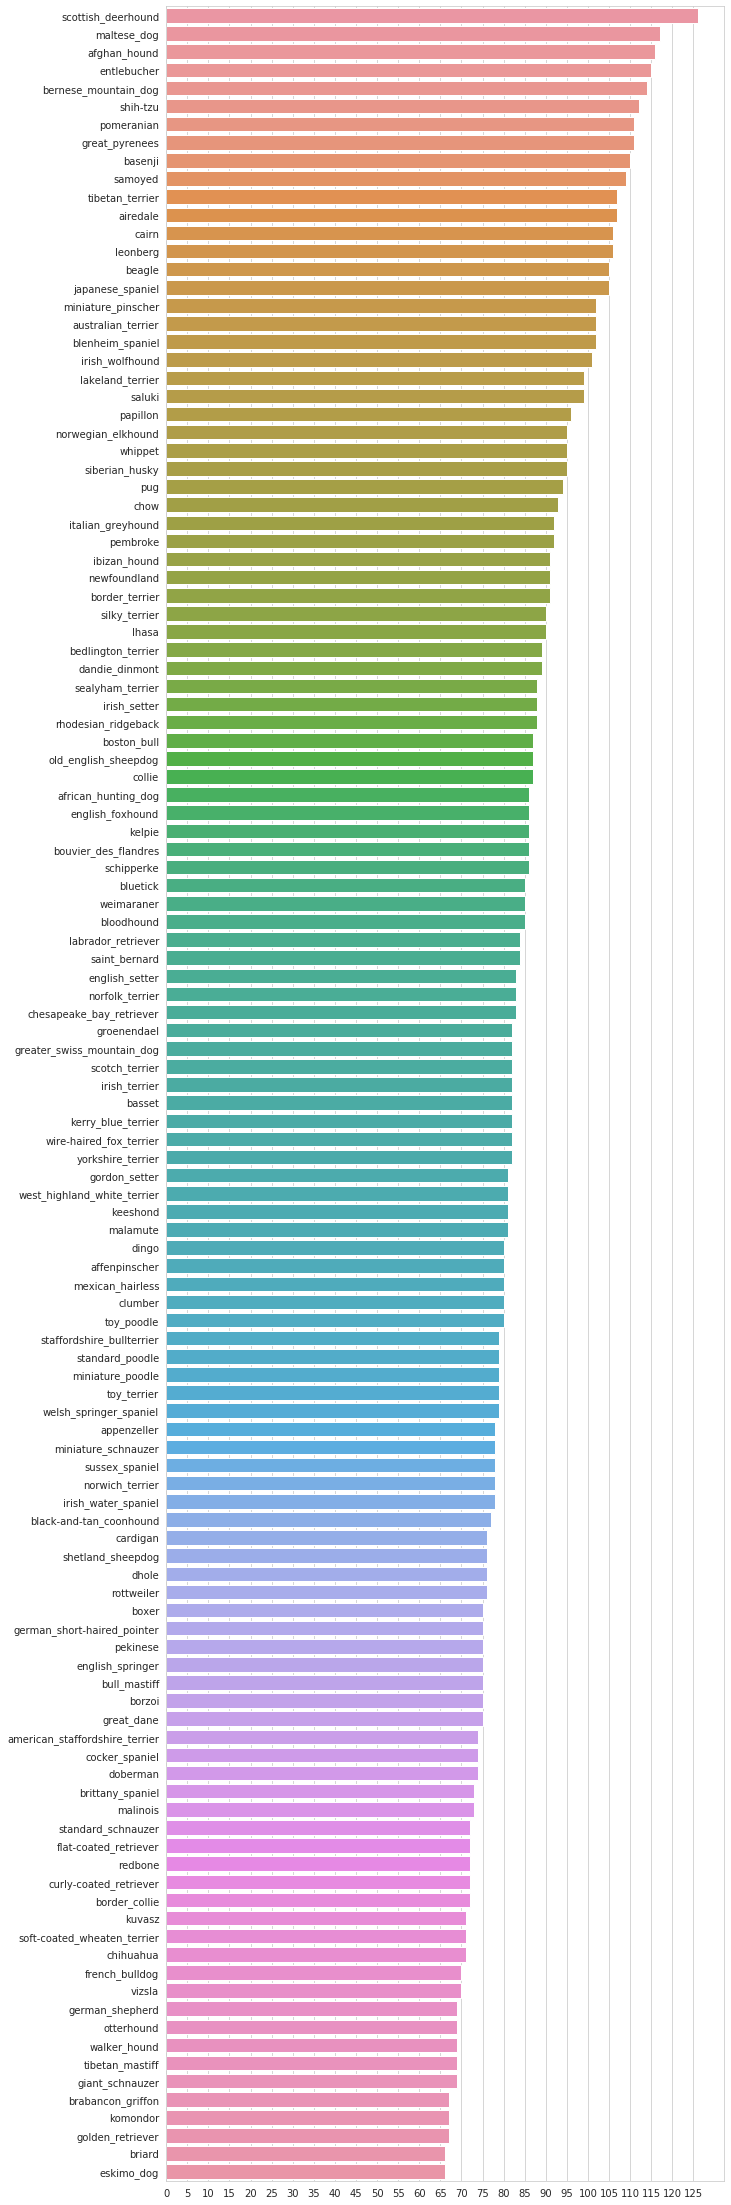

In [15]:
counts = train.breed.value_counts()
plt.figure(figsize=(10,40))
plt.xticks(np.arange(0, 130, 5))
sns.barplot(x=counts.values, y=counts.index);

In [17]:
base = VGG16(weights='imagenet', include_top=False, input_shape=(INPUT_SIZE, INPUT_SIZE, 3))
base.summary()





58892288/58889256 [==============================] - 2s 0us/step






Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________

In [0]:
#!ls /content/drive/'My Drive'/DeepLearningSem3/input/dogs-breed/train/

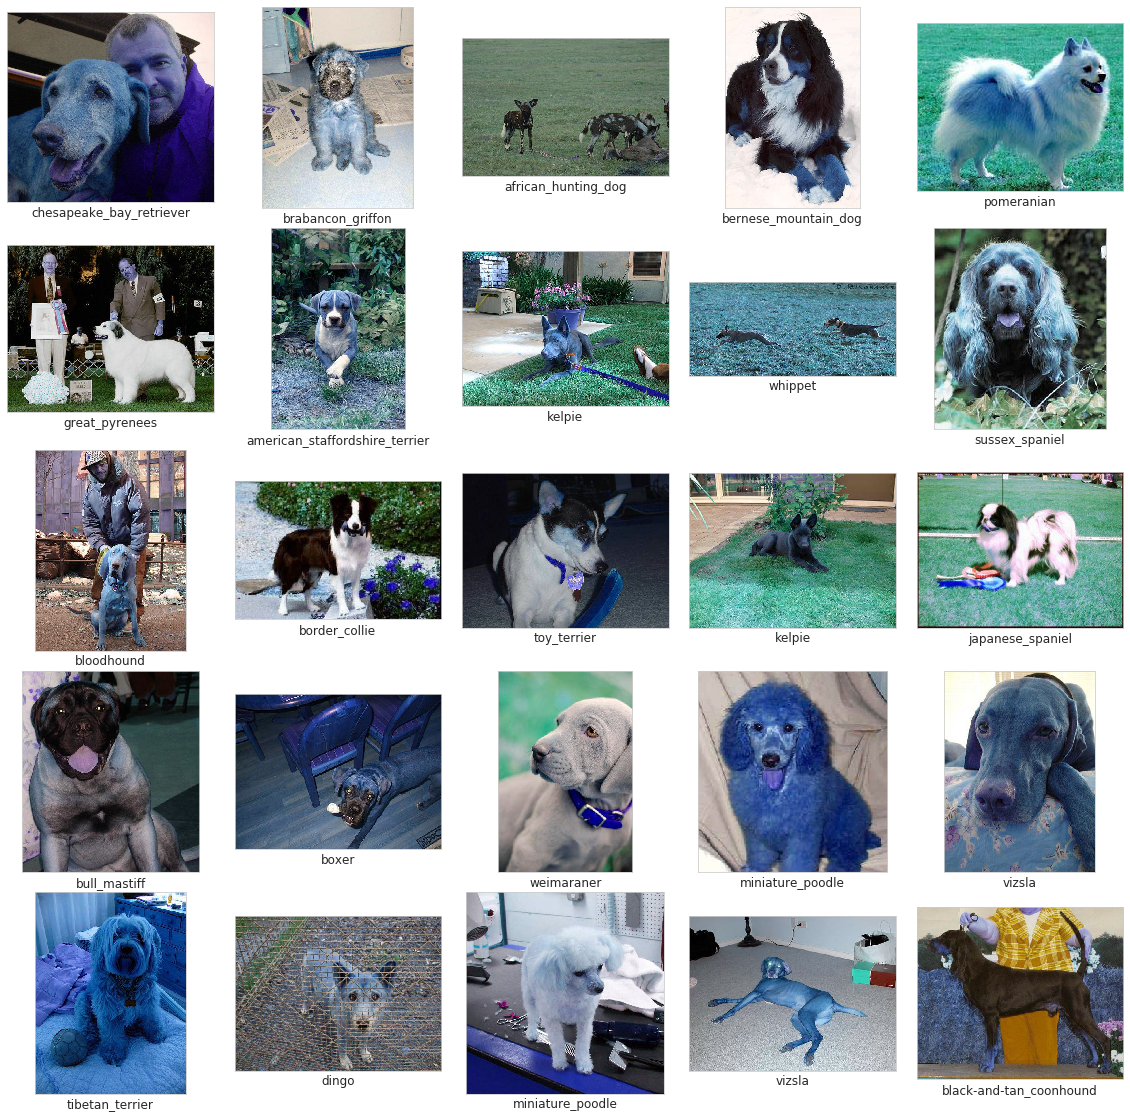

In [25]:
fig, axs = plt.subplots(5,5, figsize=(20,20), squeeze=True)
plt.subplots_adjust(wspace=0.1, hspace=0.1)
axs = axs.reshape(-1)
indices = np.random.choice(train.shape[0], 25, replace=False)
for ax, i in zip(axs, indices):
    img = cv2.imread(os.path.join('/content/drive/My Drive/DeepLearningSem3/input/dogs-breed/train/', train.iloc[i].id + '.jpg'))
    h, w, c = img.shape
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(train.iloc[i].breed, fontsize=12)
    ax.imshow(img)

In [93]:
# Make the batchsize of the data generator a divisor of the number of images, as we have
# to make just one pass for feature extraction
batch_size = 269           # 10222 = 2 * 19 * 269


#test_data["id_code"]=test_data["id_code"].apply(append_ext)
# No data augmentation, just rescaling the image
datagen = ImageDataGenerator(rescale=1./255)
#train['label'] = train['label'].astype(str)
#train['id'] = train['id'].astype(str)
train_generator = ImageDataGenerator(rescale=1/255).flow_from_dataframe(dataframe=train, 
                                              directory='/content/drive/My Drive/DeepLearningSem3/input/dogs-breed/train/',
                                              x_col= 'id',
                                              y_col='label',
                                              class_mode='categorical',
                                              has_ext=False,
                                              batch_size=batch_size,   
                                              shuffle=False,
                                              seed=42,
                                              target_size=(224,224)                                              
                                             )
train.head(4)

Found 0 validated image filenames belonging to 0 classes.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 10222 invalid image filename(s) in x_col="id". These filename(s) will be ignored.
  .format(n_invalid, x_col)


,id,breed,label
0,000bec180eb18c7604dcecc8fe0dba07.png.png,boston_bull,19.0
1,001513dfcb2ffafc82cccf4d8bbaba97.png.png,dingo,37.0
2,001cdf01b096e06d78e9e5112d419397.png.png,pekinese,85.0
3,00214f311d5d2247d5dfe4fe24b2303d.png.png,bluetick,15.0


In [45]:
%%time

# Let's read all the images and labels into arrays in memory

train_generator.reset()
train_size = train.shape[0]
features = np.zeros(shape=(train_size, 7, 7, 512))
labels = np.zeros(shape=(train_size, NUM_CLASSES))
i = 0
for inputs_batch, labels_batch in tqdm_notebook(train_generator):
    features_batch = base.predict(inputs_batch)
    features[i * batch_size:(i+1) * batch_size] = features_batch
    labels[i * batch_size:(i+1) * batch_size] = labels_batch
    i += 1
    if i * batch_size >= train_size:
        break;
   
# Flatten the output of the VGG16 base model
features = features.reshape(train_size, -1)

ValueError: ignored